# Create final model


In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import subprocess
import re
from typing import Callable
from sklearn.metrics import auc
import biotite.structure.io.pdb as pdb
import biotite.structure as struc
import numpy as np
import joblib

In [2]:
# Utility functions

def saveTemplate(path:str, atom_array, res_type=-1) -> None:
    """
    
        Save into template file using PDB format

        PARAMETERS
        ----------
        path:str path to template;
        atom_array: biotite atom array;
        res_type: int based on Tess paper (doi.org/10.1002%2Fpro.5560061104) {-1: "Template atom", 0: "Search by atom type", 
                                                                              1: "Non-carbon side chain atom", 2: "Non-carbon atom", 
                                                                              3: "Search by specified atom", 4: "Non-carbon main chain atom",
                                                                              5: "Search by any main chain atom", 6: "Search by any side chain atom",
                                                                              7: "Search by any atom type"}
    
    """
    atom_format_string = (
        "%s%7i  %-4s%3s %c%4i    %8.3f%8.3f%8.3f\n"
    )
    with open(path, "w") as fh:
        
        for atom in atom_array:
            j = tuple(["ATOM", res_type, atom.atom_name, atom.res_name, atom.chain_id, atom.res_id, atom.coord[0], atom.coord[1], atom.coord[2]])
            fh.write(atom_format_string % j)

def createTemplates(df:pd.DataFrame, out_templates:str, sub:Callable) -> list:
    """
    

        Create Jess templates

        PARAMETERS
        ----------
        df:pd.DataFrame, data frame storing isopeptide bond formations
        out_templates:str, path to output folder
        sub:Callable, function to subset atoms to be used as templates

        RETURNS
        -------
        used_templates:list, list of used templates
    
    """
    # Create templates
    shutil.rmtree(out_templates)
    os.makedirs(out_templates, exist_ok=True)
    
    # Specify conditions for templates
    
    cond1 = (df["Is bonded"] == True)
    cond2 = (df["Interchain"] == False)
    cond3 = (df["Bad rotamer"] == False)
    cond4 = (df["Residue 1"] == "K")
    cond5 = (df["Residue 2"].isin(["D", "E"]))
    cond6 = (df["Residue 2"].isin(["N", "D", "E"]))
    
    sub_df = df[cond1 & cond2 & cond3 & cond4 & cond5]
    
    # Use the same template for all to align
    ref_chain = sub_df.iloc[0]["Chain"]
    ref_pdb = sub_df.iloc[0]["PDB code"]
    ref_r1 = sub_df.iloc[0]["Position 1\r\n(Bond 1)"]
    ref_r2 = sub_df.iloc[0]["Position 2\r\n(catalytic)"]
    ref_r3 = sub_df.iloc[0]["Position 3\r\n(Bond 2)"]
    ref_residues = [ref_r1, ref_r2, ref_r3]
    
    ref_s_path = os.path.join(POSITIVE_DATASET, f"{ref_pdb}_{ref_chain}.pdb")
    pdb_file = pdb.PDBFile.read(ref_s_path)
    ref_s = pdb_file.get_structure()
    # Subset only lys
    ref_template = struc.array([atom for atom in ref_s[0] if atom.res_id == ref_r1])
    used_templates = []
    
    for _, row in sub_df.iterrows():
        chain = row["Chain"]
        pdb_code = row["PDB code"]
        r1 = row["Position 1\r\n(Bond 1)"]
        r2 = row["Position 2\r\n(catalytic)"]
        r3 = row["Position 3\r\n(Bond 2)"]
        s2_path = os.path.join(POSITIVE_DATASET, f"{pdb_code}_{chain}.pdb")
        pdb_file = pdb.PDBFile.read(s2_path) 
        s2 = pdb_file.get_structure() 
        s2_res = [r1, r2, r3]
        out_struct_path = os.path.join(OUT_TEMPLATES, f"{pdb_code}_{chain}_{int(r1)}_{int(r2)}_{int(r3)}.pdb")
        s2_sub = struc.array([atom for atom in s2[0] if atom.res_id in s2_res and "H" not in atom.atom_name])
        s2_lys = struc.array([atom for atom in s2[0] if atom.res_id == r1 and "H" not in atom.atom_name])
        s2_t = None
        try:
            _, transformation = struc.superimpose(fixed=ref_template, mobile=s2_lys)
            # Apply transformation based on K to rest of residue
            s2_t = transformation.apply(s2_sub)
            
        except ValueError:
            print(f"Transformation error for: {pdb_code}, number of residues in K {r1} is {len(s2_lys)}, expected: {len(ref_template)}")
            # Skip if no NZ
            if not "NZ" in [atom.atom_name for atom in s2_lys]:
                print("Found no NZ atom, skipping")
                continue
            # Reduce atoms from template cause mobile Lys could have less atoms (usually no N)
            atoms_to_consider = [atom.atom_name for atom in s2_lys]
            ref_template_reduced = struc.array([atom for atom in ref_template if atom.atom_name in atoms_to_consider])
            # Try again
            _, transformation = struc.superimpose(fixed=ref_template_reduced, mobile=s2_lys)
            # Apply transformation based on K to rest of residue
            s2_t = struc.superimpose_apply(s2_sub, transformation)
    
        # Subset
        s2_t = sub(s2_t)
        saveTemplate( out_struct_path, s2_t)
        used_templates.append(out_struct_path)

    return used_templates

def parse(jess_output:str) -> pd.DataFrame():
    """

        Parses Jess raw output from scanning PDB structures into a table ['target', 'rmsd', 'template', 'chain', 'target_residues', 'template_residues']
        Deprecated
    
    """
    # Parse results
    line_to_info = re.compile("REMARK ([a-z/A-Z_0-9.pdb-]{,200}) ([0-9].[0-9]{3}) ([a-z/A-Z_0-9.pdb-]{,200}) Det= [-]{,2}(?:[0-9].[0-9]|nan) log\\(E\\)~([ -]{,2}[0-9]{,3}.[0-9]{2})")
    
    outlist = []
    for line in jess_output.split("\n"):
        
        if line.startswith("REMARK"):
            try:
                match_ = line_to_info.findall(line)[0]
            except IndexError:
                print(line)
            assert len(match_) == 4, f"{match_}"
            target_path = match_[0]
            target = target_path.split("/")[-1].replace(".pdb", "")
            rmsd = float(match_[1])
            template = match_[2].split("/")[-1].replace(".pdb", "")
            loge = float(match_[3].strip())
            sublist = [target, target_path, rmsd, template]
            residues = []
            chain = None
            
        if line.startswith("ATOM"):
            chain = line[21]
            resi = int(line[22:26].strip())
            residues.append(resi)
        
        if line.startswith("ENDMDL"):
            sublist.append(chain)
            sublist.append(set(residues))
            outlist.append(sublist)
            sublist = []
        
    res_df = pd.DataFrame(outlist, columns=['target', 'target_path', 'rmsd', 'template', 'chain', 'target_residues'])
    res_df['template_residues'] = res_df["template"].apply(lambda x: set([int(i) for i in x.split("_")[2:]]))
    res_df['template'] = res_df["template"].apply(lambda x: "_".join(x.split("_")[:2]))
    res_df["target_residues"] = res_df["target_residues"].apply(lambda x: "_".join([str(_) for _ in sorted(x)]))
    res_df["template_residues"] = res_df["template_residues"].apply(lambda x: "_".join([str(_) for _ in sorted(x)]))
    res_df["target_id"] = res_df.apply(lambda x: x["target"].lower().split("_")[0]+"_"+x["chain"].lower()+"_"+x["target_residues"], axis=1)

    return res_df

def overlap(set1, set2, nbins=10):
    """
    
        Get the histogram overlap (in terms of raw counts)
    
    """
    
    rng = min(set1.min(), set2.min()), max(set1.max(), set2.max())

    hist1, _ = np.histogram(set1, bins=nbins, range=rng)
    hist2, _ = np.histogram(set2, bins=nbins, range=rng)

    return np.sum(np.minimum(hist1, hist2))

def subsetAtoms(atom_array):
    """
    
        Subset atoms from atom array
    
    """
    subset = []
    for atom in atom_array:
        
        if atom.res_name == "ASP":
            if atom.atom_name == "OD1":
                subset.append(atom)
            elif atom.atom_name == "OD2":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
                
        elif atom.res_name == "ASN":
            if atom.atom_name == "OD1":
                subset.append(atom)
            elif atom.atom_name == "ND2":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
                
        elif atom.res_name == "GLU":
            if atom.atom_name == "OE1":
                subset.append(atom)
            elif atom.atom_name == "OE2":
                subset.append(atom)
            elif atom.atom_name == "CD":
                subset.append(atom)
        
        elif atom.res_name == "LYS":
            if atom.atom_name == "NZ":
                subset.append(atom)
            elif atom.atom_name == "CE":
                subset.append(atom)

    return struc.array(subset)

MAX_ASA = { "rost_sander": { "LYS": 205, "ASP": 163, "GLU": 194, "ASN": 157 }}
def getASA(row) -> float:
    """
    
        Calculates rASA of isopep residues. Returns average value. Use mash points == 100 to speed up computation
    
    """
    rASA = np.NaN
    struct_path = row["structure_path"]
    chain = row["chain"]
    r1, r2, r3 = [int(i) for i in row["target_residues"].split("_")]
    pdb_file = pdb.PDBFile.read(struct_path)
    # Exclude water
    structure = struc.array([atom for atom in pdb_file.get_structure()[0] if atom.hetero==False and atom.chain_id==chain and atom.element!="H"])
    # Consider whole structure to calculate sASA
    try:
        structure_sasa = struc.sasa(structure, point_number=500)
        # Get indeces
        r1_indx = [i for i, atom in enumerate(structure) if atom.res_id == r1]
        r2_indx = [i for i, atom in enumerate(structure) if atom.res_id == r2]
        r3_indx = [i for i, atom in enumerate(structure) if atom.res_id == r3]

        r1_aa = structure[r1_indx[0]].res_name
        r2_aa = structure[r2_indx[0]].res_name
        r3_aa = structure[r3_indx[0]].res_name
        
        r1_asa = sum([structure_sasa[i] for i in r1_indx]) / MAX_ASA["rost_sander"][r1_aa]
        r2_asa = sum([structure_sasa[i] for i in r2_indx]) / MAX_ASA["rost_sander"][r2_aa]
        r3_asa = sum([structure_sasa[i] for i in r3_indx]) / MAX_ASA["rost_sander"][r3_aa]
        
        rASA = [r1_asa, r2_asa, r3_asa]
        
    except IndexError:
        ""
        rASA = np.NaN
        
    except KeyError:
        rASA = np.NaN

    return rASA

In [3]:
from dotenv import load_dotenv
load_dotenv("../../.env")
JESS = os.getenv("JESS")
NEGATIVE_DATASET = os.getenv("NEGATIVE_CONTROL_3") + "_training"
POSITIVE_DATASET = os.getenv("POSITIVE_CONTROL")
TABLE = os.getenv("TABLE")
POSITIVE_CONTROL_IDENTITIES = os.getenv("POSITIVE_CONTROL_IDENTITIES")
INPUT_STRUCTURES_FILES = "output/structures"
AF2_POS_SET = os.getenv("AF2_POS_SET")
AF2_POS_SET_TEMPLATES = os.getenv("AF2_POS_SET_TEMPLATES")
AF2_BIOCHEM = os.getenv("AF2_BIOCHEM")
AF2_TEMPLATES_BIOCHEM = os.getenv("AF2_TEMPLATES_BIOCHEM")
TEMPLATES_DIR = "/nfs/research/agb/research/francesco/projects/20240212_isopeptideBonds_v1/20240529_findWithJess_v1/analysis/20241126_testTemplates_v1/output/templates/set7"
POS_SET_SEQ_ID = os.getenv("POS_SET_SEQ_ID")
CACHE_TABLE = "output/jess_scan.csv"
TEST_CACHE_TABLE = "output/jess_scan_test.csv"

In [4]:
df = pd.read_csv(TABLE)
df["id"] = df.apply(lambda x: f"{x['PDB code']}_"+
                    x["Chain"]+"_"+"_".join( 
                        [str(i) for i in sorted(
                            [
                            x["Position 1\r\n(Bond 1)"],
                            x["Position 2\r\n(catalytic)"],
                            x["Position 3\r\n(Bond 2)"]
                            ]
                            )]
                            ), axis=1)

identity_df = pd.read_csv(POS_SET_SEQ_ID)
identity_df["Target"] = identity_df["Target"].str.lower()
identity_df["Query"] = identity_df["Query"].str.lower()

In [5]:
af_df = pd.read_csv(AF2_BIOCHEM)
af_df["id"] = af_df.apply(lambda x: x["PDB code"]+\
                          "_"+ "_".join([str(i) for i in sorted(
                              [x["r1_af"], 
                               x["r2_af"], 
                               x["r3_af"]])]), 
                          axis=1).str.lower()

af_templ_df = pd.read_csv(AF2_TEMPLATES_BIOCHEM)
af_templ_df["id"] = af_templ_df.apply(lambda x: x["PDB code"]+\
                          "_"+ "_".join([str(i) for i in sorted(
                              [x["r1_af"], 
                               x["r2_af"], 
                               x["r3_af"]])]), 
                          axis=1).str.lower()



In [6]:
# Create template file
TEMPLATES = "output/templates"
with open(TEMPLATES, "w") as fh:
    for file in os.listdir(TEMPLATES_DIR):
        if not file.endswith(".pdb"):
            continue
        tmp_file = os.path.join(TEMPLATES_DIR, file)
        fh.write(tmp_file+"\n")

## Run Jess

In [7]:
# Create files
# Create input structures file
input_structures_file = "output/structures"
with open(input_structures_file, "w") as fh:
    for neg_file in os.listdir(NEGATIVE_DATASET):   
        if neg_file.split(".")[-1] != "pdb":
            continue
        # Verify no negative files overlap with positive dataset
        if neg_file.split("/")[-1].replace(".pdb", "").lower() in df["PDB code"].unique():
            print(neg_file)
            continue
        fh.write(os.path.join(NEGATIVE_DATASET, neg_file)+"\n")
    for pos_file in os.listdir(POSITIVE_DATASET):
        if pos_file.split(".")[-1] != "pdb":
            continue
        fh.write(os.path.join(POSITIVE_DATASET, pos_file)+"\n")

In [18]:
# Run Jess
distances = [5]
if os.path.exists(CACHE_TABLE) == False:
    res_df = pd.DataFrame()
    for distance in distances:
        # Distance must be 1.5*RMSD
        rmsd_threshold, distance_cutoff, max_allowed_distance = [str(distance)]*3
        cmd = [str(JESS), str(TEMPLATES), str(input_structures_file), rmsd_threshold, distance_cutoff, max_allowed_distance]
        process = subprocess.Popen(
        cmd, text=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
        )
        stdout, stderr = process.communicate()
        res_df = parse(stdout)
    
    # Assign true positive
    cond1 = (df["Is bonded"] == True)
    cond2 = (df["Interchain"] == False)
    cond3 = (df["Bad rotamer"] == False)
    cond4 = (df["Unusual geometry/chemistry"]==False)
    cond5 = (df["Resolution"]<=2.5)
    res_df["true_positive"] = 0
    templates = df[cond1 & cond2 & cond3 & cond4 & cond5]["id"].str.lower().to_list()
    res_df.loc[res_df["target_id"].isin(templates), "true_positive"] = 1
    
    # Assign bad rotamer or low resolution (so they can later on be excluded)
    res_df["bad_rotamer_low_res"] = 0
    cond1 = (df["Bad rotamer"] == True)
    cond2 = (df["Resolution"] > 2.5)
    templates = df[(cond1 | cond2) | (cond1 & cond2)]["id"].str.lower().to_list()
    res_df.loc[res_df["target_id"].isin(templates), "bad_rotamer_low_res"] = 1
    
    # Assign path
    path_df = pd.read_csv(input_structures_file, names=["structure_path"]).drop_duplicates()
    path_df["PDB code"] = path_df["structure_path"].apply(lambda x: x.split("/")[-1].split("_")[0].replace(".pdb", "").lower())
    res_df["PDB code"] = res_df["target"].apply(lambda x: x.split("_")[0].lower())
    res_df = pd.merge(res_df, path_df, how="left")
    
    # Get rASA
    asa_df = res_df.drop_duplicates("target_id").copy()
    asa_df["rASA"] = asa_df.apply(getASA, axis=1)
    
    asa_df["tot_rASA"] = asa_df["rASA"].apply(lambda x: np.sum(x))
    asa_df["mean_rASA"] = asa_df["rASA"].apply(lambda x: np.mean(x))
    
    res_df["template_id"] = res_df.apply(lambda x: x["template"].lower()+"_"+x["template_residues"], axis=1)
    res_df = pd.merge(res_df, asa_df[["target_id", "tot_rASA", "mean_rASA"]])
    res_df.to_csv(CACHE_TABLE, index=False)
else:
    res_df = pd.read_csv(CACHE_TABLE)

## Create logitic regression model

In [19]:
from sklearn.linear_model import LogisticRegression

In [18]:
res_df = pd.read_csv(CACHE_TABLE)

In [10]:
# Avoid matches target-template above 30% seq idenity
# Exclude bad rotamers and low res isopeptide bonds
cond1 = (res_df["bad_rotamer_low_res"]==0)
cond2 = (~res_df["mean_rASA"].isna())
cond3 = (identity_df["identity"]>0.3)
mod_df = pd.merge(res_df[cond1 & cond2], 
                identity_df[cond3].rename(columns={"Query":"target_id", "Target":"template_id"})\
           .assign(allowed=0), on=["target_id", "template_id"], how="left").fillna(1)\
           .query('allowed==1').query('target_id!=template_id')\
           .sort_values("rmsd").drop_duplicates(["target", "target_residues"], keep="first")

In [11]:
X = mod_df[["rmsd", "mean_rASA"]].to_numpy()
y = mod_df["true_positive"].to_numpy()

clf = LogisticRegression(random_state=1).fit(X, y)

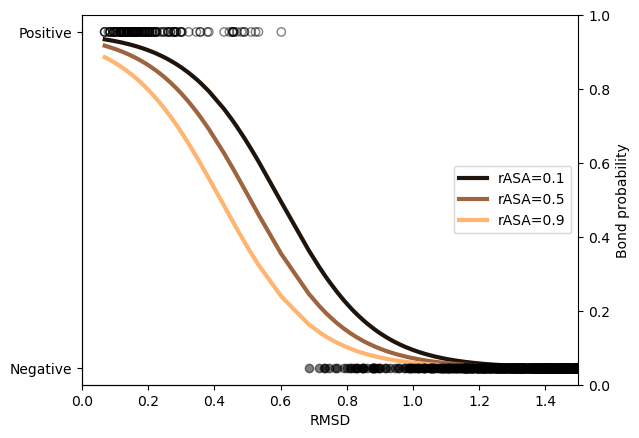

In [12]:
fig, ax = plt.subplots()

sns.scatterplot(mod_df[mod_df["true_positive"]==1], x="rmsd", y="true_positive", alpha=.5, lw=1, ax=ax, edgecolors="black", 
               facecolors='none')
sns.scatterplot(mod_df[mod_df["true_positive"]==0], x="rmsd", y="true_positive", alpha=.5, lw=1, ax=ax, edgecolors="black", 
               facecolors='black')

copper = plt.get_cmap('copper')
for mean_asa in [0.1, 0.5, 0.9]:
    X =  mod_df.sort_values(["rmsd", "mean_rASA"])[["rmsd", "mean_rASA"]].assign(mean_rASA=mean_asa).to_numpy()
    ax.plot(X[:,0], clf.predict_proba(X)[:,1], alpha=1, lw=3, ls="-", color=copper(mean_asa), zorder=0,
            label = f"rASA={mean_asa}")
ax.legend(loc="center right")
ax.set_yticks([0, 1])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("")
ax.set_xlabel("RMSD")
ax.set_yticks([0,1], ["Negative", "Positive"])
ax.set_xlim([0,1.5])

ax_r = ax.twinx()
ax_r.set_ylabel('Bond probability', color="black")
ax_r.tick_params(axis='y', labelcolor="black")

In [13]:
joblib.dump(clf, "output/model.pkl")

['output/model.pkl']

## Run tests
Use negative test set and bad rotamers as positive set 

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

clf = joblib.load("output/model.pkl")

/nfs/research/agb/research/francesco/anaconda3/envs/isopeptide/lib/python3.12/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.1.post1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### On test set

In [7]:
# Create input structure file
positive_set = os.path.join(POSITIVE_DATASET+"_unfixed")
negative_set = os.path.join(os.getenv("NEGATIVE_CONTROL_3")+"_test")
input_structures_file = "output/test_structures"
with open(input_structures_file, "w") as fh:
    for file in os.listdir(positive_set):
        fh.write(os.path.join(positive_set, file)+"\n")
    for file in os.listdir(negative_set):
        fh.write(os.path.join(negative_set, file)+"\n")

In [8]:
# Run Jess
distances = [5]
if os.path.exists(TEST_CACHE_TABLE) == False:
    res_df = pd.DataFrame()
    for distance in distances:
        # Distance must be 1.5*RMSD
        rmsd_threshold, distance_cutoff, max_allowed_distance = [str(distance)]*3
        cmd = [str(JESS), str(TEMPLATES), str(input_structures_file), rmsd_threshold, distance_cutoff, max_allowed_distance]
        process = subprocess.Popen(
        cmd, text=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
        )
        stdout, stderr = process.communicate()
        res_df = parse(stdout)
    
    # Assign potential true positive from training set (so they can later on be excluded)
    # Include low resolution
    cond1 = (df["Is bonded"] == True)
    cond2 = (df["Interchain"] == False)
    cond3 = (df["Bad rotamer"] == False)
    cond4 = (df["Unusual geometry/chemistry"]==False)
    cond5 = (df["Resolution"]>2.5)
    # Exclude fixed==True because I am using those
    cond6 = (~df["Fixed"]==True)
    res_df["true_positive_training_or_low_res"] = 0
    templates = df[((cond1 & cond2 & cond3 & cond4)|cond5)&cond6]["id"].str.lower().to_list()
    res_df.loc[res_df["target_id"].isin(templates), "true_positive_training_or_low_res"] = 1
    
    # Assign true positive test
    cond1 = (df["Is bonded"] == True)
    cond2 = (df["Interchain"] == False)
    cond3 = (df["Resolution"] <= 2.5)
    cond4 = (df["Bad rotamer"] == True)
    cond5 = (df["Fixed"] == True)
    res_df["true_positive"] = 0
    templates = df[(cond1 & cond2 & cond3) & (cond4 | cond5)]["id"].str.lower().to_list()
    res_df.loc[res_df["target_id"].isin(templates), "true_positive"] = 1
    
    # Assign path
    path_df = pd.read_csv(input_structures_file, names=["structure_path"]).drop_duplicates()
    path_df["PDB code"] = path_df["structure_path"].apply(lambda x: x.split("/")[-1].split("_")[0].replace(".pdb", "").lower())
    res_df["PDB code"] = res_df["target"].apply(lambda x: x.split("_")[0].lower())
    res_df = pd.merge(res_df, path_df, how="left")
    
    # Get rASA
    asa_df = res_df.drop_duplicates("target_id").copy()
    asa_df["rASA"] = asa_df.apply(getASA, axis=1)
    
    asa_df["tot_rASA"] = asa_df["rASA"].apply(lambda x: np.sum(x))
    asa_df["mean_rASA"] = asa_df["rASA"].apply(lambda x: np.mean(x))
    
    res_df["template_id"] = res_df.apply(lambda x: x["template"].lower()+"_"+x["template_residues"], axis=1)
    res_df = pd.merge(res_df, asa_df[["target_id", "tot_rASA", "mean_rASA"]])
    res_df.to_csv(TEST_CACHE_TABLE, index=False)
else:
    res_df = pd.read_csv(TEST_CACHE_TABLE)

In [9]:
# Avoid matches target-template above 30% seq idenity
cond1 = (res_df["true_positive_training_or_low_res"]==0)
cond2 = (~res_df["mean_rASA"].isna())
cond3 = (identity_df["identity"]>0.3)
test_df = pd.merge(res_df[cond1 & cond2], 
                identity_df[cond3].rename(columns={"Query":"target_id", "Target":"template_id"})\
           .assign(allowed=0), on=["target_id", "template_id"], how="left").fillna(1)\
           .query('allowed==1').query('target_id!=template_id')\
           .sort_values("rmsd").drop_duplicates(["target", "target_residues"], keep="first")

In [10]:
y_true = test_df["true_positive"].to_numpy()
y_pred = clf.predict(test_df[["rmsd", "mean_rASA"]].to_numpy())
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

In [11]:
print(f"Precision: {round(precision, 3)}, Recall: {round(recall, 3)}, F1-score: {round(f1, 3)}")

Precision: 0.792, Recall: 1.0, F1-score: 0.884


### On AF2 structures modelled without templates

In [8]:
# Run on AF2
distance = 5
pdb_files = [os.path.join(AF2_POS_SET_TEMPLATES, dir_, "ranked_0.pdb") for dir_ in os.listdir(AF2_POS_SET)]
rmsd_threshold, distance_cutoff, max_allowed_distance = [str(distance)]*3
cmd = [str(JESS), str(TEMPLATES), "-", rmsd_threshold, distance_cutoff, max_allowed_distance]

process = subprocess.Popen(
    cmd, text=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
)
stdout, stderr = process.communicate(input="\n".join(pdb_files))
res_df = parse(stdout)
res_df["target"] = res_df["target_path"].apply(lambda x: x.split("/")[-2]) 
res_df["structure_path"] = res_df["target_path"]
res_df["target_id"] = res_df.apply(lambda x: x["target"].split("_")[0]+\
                            "_"+"_".join(x["target_id"].split("_")[2:]), axis=1)
res_df["target_pdb_code"] = res_df["target"].apply(lambda x: x.split("_")[0])

# Get asa
asa_df = res_df.drop_duplicates("target_id").copy()
asa_df["rASA"] = asa_df.apply(getASA, axis=1)
asa_df["tot_rASA"] = asa_df["rASA"].apply(lambda x: np.sum(x))
asa_df["mean_rASA"] = asa_df["rASA"].apply(lambda x: np.mean(x))
res_df["template_id"] = res_df.apply(lambda x: x["template"].lower()+"_"+x["template_residues"], axis=1)
res_df = pd.merge(res_df, asa_df[["target_id", "tot_rASA", "mean_rASA"]])

# Get TP
cond1 = (af_df["Is bonded"])
cond2 = (~af_df["Interchain"])
true_pos = af_df[cond1 & cond2]["id"].to_list()
res_df["true_positive"] = 0
res_df.loc[res_df["target_id"].isin(true_pos), "true_positive"] = 1

In [21]:
# Map AF2 to PDB ids
map_df = pd.merge(af_templ_df, 
    df[["PDB code", "Chain", "Position 1\r\n(Bond 1)", "id"]].rename(columns={"id": "target_id_pdb"}), on=["PDB code", "Chain", "Position 1\r\n(Bond 1)"])
# Introduce PDB id as target_id_pdb
test_df = pd.merge(res_df,
                   map_df[["id", "target_id_pdb"]].rename(columns={"id":"target_id"}).assign(target_id_pdb=lambda x: x["target_id_pdb"].str.lower()),\
                   on="target_id", how="left")
# Avoid matches target-template above 30% seq idenity
cond1 = (~test_df["mean_rASA"].isna())
test_df = pd.merge(test_df[cond1], 
                identity_df.rename(columns={"Query":"target_id_pdb", "Target":"template_id"}),\
           on=["target_id_pdb", "template_id"], how="left")\
           .fillna({"identity":0})\
           .query('identity<.3').query('target_id!=template_id')\
           .sort_values("rmsd").drop_duplicates(["target", "target_residues"], keep="first")

In [22]:
# Recall is the only metric that makes sense since there is no proper negative set:
y_true = test_df["true_positive"].to_numpy()
y_pred = clf.predict(test_df[["rmsd", "mean_rASA"]].to_numpy())
recall = recall_score(y_true, y_pred)
print(f"Recall: {round(recall, 3)}")

Recall: 0.927


### On AF2 structures modelled without templates

In [13]:
# Run on AF2
distance = 5
pdb_files = [os.path.join(AF2_POS_SET, dir_, "ranked_0.pdb") for dir_ in os.listdir(AF2_POS_SET)]
rmsd_threshold, distance_cutoff, max_allowed_distance = [str(distance)]*3
cmd = [str(JESS), str(TEMPLATES), "-", rmsd_threshold, distance_cutoff, max_allowed_distance]

process = subprocess.Popen(
    cmd, text=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
)
stdout, stderr = process.communicate(input="\n".join(pdb_files))
res_df = parse(stdout)
res_df["target"] = res_df["target_path"].apply(lambda x: x.split("/")[-2]) 
res_df["structure_path"] = res_df["target_path"]
res_df["target_id"] = res_df.apply(lambda x: x["target"].split("_")[0]+\
                            "_"+"_".join(x["target_id"].split("_")[2:]), axis=1)
res_df["target_pdb_code"] = res_df["target"].apply(lambda x: x.split("_")[0])

# Get asa
asa_df = res_df.drop_duplicates("target_id").copy()
asa_df["rASA"] = asa_df.apply(getASA, axis=1)
asa_df["tot_rASA"] = asa_df["rASA"].apply(lambda x: np.sum(x))
asa_df["mean_rASA"] = asa_df["rASA"].apply(lambda x: np.mean(x))
res_df["template_id"] = res_df.apply(lambda x: x["template"].lower()+"_"+x["template_residues"], axis=1)
res_df = pd.merge(res_df, asa_df[["target_id", "tot_rASA", "mean_rASA"]])

# Get TP
cond1 = (af_df["Is bonded"])
cond2 = (~af_df["Interchain"])
true_pos = af_df[cond1 & cond2]["id"].to_list()
res_df["true_positive"] = 0
res_df.loc[res_df["target_id"].isin(true_pos), "true_positive"] = 1

NameError: name 'TEMPLATES' is not defined

In [24]:
# Map AF2 to PDB ids
map_df = pd.merge(af_df, 
    df[["PDB code", "Chain", "Position 1\r\n(Bond 1)", "id"]].rename(columns={"id": "target_id_pdb"}), on=["PDB code", "Chain", "Position 1\r\n(Bond 1)"])
# Introduce PDB id as target_id_pdb
test_df = pd.merge(res_df,
                   map_df[["id", "target_id_pdb"]].rename(columns={"id":"target_id"}).assign(target_id_pdb=lambda x: x["target_id_pdb"].str.lower()),\
                   on="target_id", how="left")
# Avoid matches target-template above 30% seq idenity
cond1 = (~test_df["mean_rASA"].isna())
test_df = pd.merge(test_df[cond1], 
                identity_df.rename(columns={"Query":"target_id_pdb", "Target":"template_id"}),\
           on=["target_id_pdb", "template_id"], how="left")\
           .fillna({"identity":0})\
           .query('identity<.3').query('target_id!=template_id')\
           .sort_values("rmsd").drop_duplicates(["target", "target_residues"], keep="first")

In [25]:
# Recall is the only metric that makes sense since there is no proper negative set:
y_true = test_df["true_positive"].to_numpy()
y_pred = clf.predict(test_df[["rmsd", "mean_rASA"]].to_numpy())
recall = recall_score(y_true, y_pred)
print(f"Recall: {round(recall, 3)}")

Recall: 0.911


## Run cross validation

In [82]:
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.model_selection import cross_validate

In [83]:
res_df = pd.read_csv(CACHE_TABLE)
# After having run python bin/cluster_matches.py:
clus_df = pd.read_csv("output/cluster.csv")

In [98]:
# Keep only representative clusters
clus_representatives = clus_df.drop_duplicates("cluster", keep="first")["Query"].str.lower().to_list()
cond1 = (res_df["target_id"].isin(clus_representatives))
cond2 = (res_df["template_id"].isin(clus_representatives))
cond3 = (res_df["target_id"]!=res_df["template_id"])
cond4 = (res_df["bad_rotamer_low_res"]==0)
cond5 = (~res_df["mean_rASA"].isna())
val_df = res_df[cond1 & cond2 & cond3 & cond4 & cond5]\
        .sort_values("rmsd")\
        .drop_duplicates("target_id", keep="first")


In [99]:
# Shuffle
val_df = val_df.sample(frac=1, random_state=3)


X = val_df[["rmsd", "mean_rASA"]].to_numpy()
y = val_df["true_positive"].to_numpy()

gkf = StratifiedKFold(n_splits=4)

clf = LogisticRegression()

r = cross_validate(
        clf, X, y, cv=gkf, scoring=['precision','f1','recall']
    )

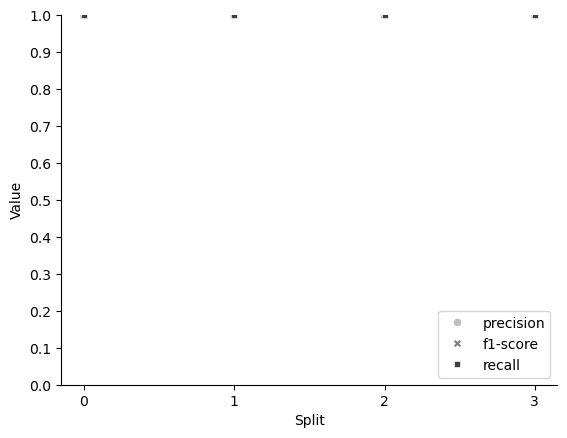

In [102]:
fig, ax = plt.subplots()

sns.scatterplot(pd.DataFrame(r)[["test_precision", "test_f1", "test_recall"]]\
                .rename(columns={"test_precision": "precision", "test_f1": "f1-score", "test_recall": "recall"}), 
                palette="binary")
plt.ylim([0,1])

plt.ylabel("Value")
plt.xlabel("Split",)

plt.xticks([0, 1, 2, 3])
plt.yticks([i/10 for i in range(0,11,1)])

plt.legend(loc="lower right")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [105]:
pd.DataFrame(r).describe().round(2)

,fit_time,score_time,test_precision,test_f1,test_recall
count,4.0,4.00,4.0,4.0,4.0
mean,0.0,0.01,1.0,1.0,1.0
std,0.0,0.00,0.0,0.0,0.0
min,0.0,0.01,1.0,1.0,1.0
25%,0.0,0.01,1.0,1.0,1.0
50%,0.0,0.01,1.0,1.0,1.0
75%,0.0,0.01,1.0,1.0,1.0
max,0.0,0.01,1.0,1.0,1.0
